In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from data_processing import *

np.random.seed(42)

In [2]:
alldat = load_data()

In [3]:
# d = alldat[0]
for i,d in enumerate(alldat):
    # print(d.keys())
    # print("Number of neurons: {}\nNumber of trials: {}\nNumber of timesteps: {}".format(*d['spks'].shape))
    if "MOs" in d["brain_area"]:
        print("Session", i)
        print("Recorded brain areas:", *["{} ({}),".format(*elem) for elem in zip(*np.unique(d['brain_area'], return_counts=True))])

Session 0
Recorded brain areas: ACA (109), CA3 (68), DG (34), LS (139), MOs (113), SUB (75), VISp (178), root (18),
Session 3
Recorded brain areas: ACA (304), CA1 (98), DG (144), LGd (140), LSr (435), MOs (92), SUB (108), TH (256), VISa (81), VISp (39), VPL (72),
Session 4
Recorded brain areas: ACA (53), CA1 (28), DG (16), MOs (29), OLF (181), ORB (32), PL (14), SUB (101), VISa (99), root (524),
Session 7
Recorded brain areas: CA1 (56), CA3 (17), DG (33), ILA (144), LD (41), LP (120), LSr (3), MOs (112), PL (144), PO (255), SUB (34), TT (82), VISa (63), VISp (48), root (4),
Session 11
Recorded brain areas: ACA (16), CA1 (50), DG (65), LGd (11), LH (18), MD (126), MOs (6), PL (56), SUB (105), VISam (79), VISp (66), root (100),
Session 12
Recorded brain areas: ACA (58), CA1 (34), DG (17), LGd (150), MB (63), MOs (46), MRN (51), MS (23), PL (184), RN (58), SCm (45), SCs (32), VISam (34), ZI (15), root (173),
Session 13
Recorded brain areas: CA1 (99), MOs (186), MRN (72), ORB (170), PAG (1

In [4]:
def print_trial_outcome(dat, trial_idx):
    if dat['contrast_left'][trial_idx] != 0 and dat['contrast_right'][trial_idx] != 0:
        stimulus = "Both left: {}%, right: {}%".format(dat['contrast_left'][trial_idx]*100, 100*dat['contrast_right'][trial_idx]) 
    elif dat['contrast_left'][trial_idx] != 0.0:
        stimulus = "Left {}%".format(dat['contrast_left'][trial_idx]*100)
    elif dat['contrast_right'][trial_idx] != 0.0:
        stimulus = "Right {}%".format(dat['contrast_right'][trial_idx]*100)
    else:
        stimulus = "Neither"
    
    response = ["Right", "NoGo", "Left"][int(dat['response'][trial_idx]+1)]
    
    feedback = "Reward" if dat['feedback_type'][trial_idx] == 1 else "White noise"
    
    print("-------- Trial number {} --------".format(trial_idx))
    print("Stimulus:", stimulus)
    print("Response:", response)
    print("Feedback:", feedback)
    

def plot_vlines(dat, trial_idx, label=False):
#     plt.axvline(0, color="black", linestyle=":", label="Stim onset" if label else "")
    plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle="--", label="Go cue" if label else "")
    plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback" if label else "")
#     plt.axvline(dat['response_time'][trial_idx,0], color="tab:orange", linestyle="--", label="Response" if label else "")
    

In [5]:
def train_hmm(spk, brain_area, n_states, start=0, stop=250, n_iters=100):
    dat = alldat[session]
    spks = dat['spks'][dat['brain_area'] == brain_area]
    spks = spks[:,:,start:stop]
    data= np.transpose(spks, (1,2,0)) # n_trials x n_timesteps x n_neurons
    
    # train/test split
    train_data, test_data, rdm_idx = data_split(data, int(0.8*len(data)))
    mean_spike_counts = train_data.mean(axis=(0,1))
    train_data = list(train_data)
    test_data = list(test_data)

    n_neurons = train_data[0].shape[1]
    
    # create the hmm
    hmm = ssm.HMM(n_states, n_neurons, observations="poisson", transitions="standard")

    # initialization
    init_lambdas = np.random.uniform(low=np.zeros_like(mean_spike_counts),
                                     high=mean_spike_counts, size=(n_states,n_neurons)) # n_states x n_neurons
    hmm.log_lambdas = np.log(init_lambdas + 1e-16)
    
    lls = hmm.fit(list(train_data), method='em', num_iters=n_iters)
    
    return hmm, lls, dat, rdm_idx, train_data, test_data


def viz_hmm(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res    
    
    print("Train ll:", lls[-1])
    test_ll = hmm.log_likelihood(list(test_data))
    print("Test ll:", test_ll)
    plt.plot(lls)
    plt.title("Log likelihood")
    plt.show()
    
    
    learned_transition_mat = hmm.transitions.transition_matrix

    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(learned_transition_mat)
    plt.title("Learned transition matrix")

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    fig = plt.figure(figsize=(8, 8))
    for i, log_lambda in enumerate(hmm.observations.log_lambdas):
        plt.subplot(len(hmm.observations.log_lambdas), 1, i+1)
        plt.title("Latent state {}".format(i))
        plt.bar(np.arange(len(log_lambda)), np.exp(log_lambda))
        print(np.argmax(log_lambda))
    plt.tight_layout()
    plt.show()
    
    test_trial = 5
    test_trial_spikes = train_data[test_trial]
    print_trial_outcome(dat, rdm_idx[test_trial])
    
    posterior = hmm.filter(test_trial_spikes)
    n_states = posterior.shape[1]
    # plot posterior of states for a single test trial
    plt.figure(figsize=(10, 4))
    plt.title("Posterior distribution of the latent state")
    for i in range(n_states):
        plt.plot(posterior[:,i], label="State %d" % i)
    plt.legend()
    plt.show()
    
    
    # plot the most likely hidden states
    ml_states = hmm.most_likely_states(test_trial_spikes)
    plt.figure(figsize=(8, 2))
    plt.imshow(ml_states[None,:], aspect="auto", vmin=0, vmax=n_states-1)
    


#     plt.figure(figsize=(10, 4))
#     plt.plot(dat['wheel'][0,rdm_idx[test_trial]])
#     plt.show()
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(dat['face'][0,rdm_idx[test_trial]])
#     plt.show()

In [23]:
def plot_posterior(res, n_trials=10, plot_wheel=False, plot_face=False, plot_pupil=False):
    hmm, lls, dat, rdm_idx, train_data, test_data = res
    
    dt = 0.01 # bin duration (ms)
    t = np.arange(dat['spks'].shape[2])*dt
    t -= 0.5 # set timestep 0 to stimulus onset 

    for trial in range(n_trials):
        trial_spikes = train_data[trial]
        print_trial_outcome(dat, rdm_idx[trial])
        posterior = hmm.filter(trial_spikes)
        n_states = posterior.shape[1]

        # plot posterior of states for a single test trial
        plt.figure(figsize=(10, 2))
        plt.title("Posterior distribution of the latent state")

        for i in range(posterior.shape[1]):
            plt.plot(t, posterior[:,i], label="State %d" % i)

#         ml_states = hmm.most_likely_states(trial_spikes)
#         plt.figure(figsize=(8, 1))
#         plt.imshow(ml_states[None,:], aspect="auto", vmin=0, vmax=n_states-1)
    
            
#         plot_vlines(dat, rdm_idx[trial], label=True if trial==0 else False)
        plot_vlines(dat, rdm_idx[trial], label=True)

        
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.legend()
        plt.show()

        if plot_wheel:
            plt.figure(figsize=(10, 2))
            plt.plot(t, np.cumsum(dat['wheel'][0,rdm_idx[trial]]))
            plt.xlabel("Time (s)")
            plt.ylabel("Wheel position")
            plt.show()

        if plot_pupil:
            plt.figure(figsize=(10, 2))
            # plt.plot(dat['pupil'][0,rdm_idx[trial]])
            plt.plot(t, dat['pupil'][1,rdm_idx[trial]])
            plt.plot(t, dat['pupil'][2,rdm_idx[trial]])
            plt.xlabel("Time (s)")
            plt.ylabel("Pupil position")
            plt.show()

        if plot_face:
            plt.figure(figsize=(10, 2))
            plt.plot(t, dat['face'][0,rdm_idx[trial]])
            plt.xlabel("Time (s)")
            plt.ylabel("Face motion")
            plt.show()


In [16]:
def fact_corr(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res

    mean_corr = np.zeros(n_states)
    for i, spks in enumerate(train_data):
        posterior = hmm.filter(spks)
        head_motion = dat['face'][0,rdm_idx[i]]
    #     head_motion = dat['wheel'][0,rdm_idx[i]]

        if head_motion.std() != 0:
            for j in range(posterior.shape[1]):
                corr = np.corrcoef(posterior[:,j], head_motion)[0,1]
                mean_corr[j] = i/(i+1)*mean_corr[j] + corr/(i+1)

def stim_corr(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res

#     right_mean_corr = np.zeros(n_states)
#     left_mean_corr = np.zeros(n_states)
    
    right_corr = []
    left_corr = []
    
    for i, spks in enumerate(train_data):
        posterior = hmm.filter(spks)

        contrast_left = dat['contrast_left'][rdm_idx[i]]
        contrast_right = dat['contrast_right'][rdm_idx[i]] 
        
        is_stim = np.zeros(len(spks))
        feedback_idx = ( dat['feedback_time'][rdm_idx[i]]+0.5 ) // 0.01
#         is_stim[50:int(feedback_idx)] = 1
        is_stim[50:100] = 1

        
        right_stim = is_stim if contrast_right != 0 and contrast_left == 0 else np.zeros(len(spks))
        left_stim = is_stim if contrast_left != 0 and contrast_right == 0 else np.zeros(len(spks))

        n_states = posterior.shape[1]
        
        if (right_stim != 0).any():
            right_corr_trial = np.zeros(n_states)
            for j in range(n_states):
                corr = np.sum(np.abs(right_stim - posterior[:,j]))
#                 corr = np.corrcoef(posterior[:,j], right_stim)[0,1]
                # right_mean_corr[j] = i/(i+1)*right_mean_corr[j] + corr/(i+1)        
                right_corr_trial[j] = corr if np.isfinite(corr) else 0
            right_corr.append(right_corr_trial)

        if (left_stim != 0).any():
            left_corr_trial = np.zeros(n_states)
            for j in range(n_states):
                corr = np.sum(np.abs(left_stim - posterior[:,j]))
#                 corr = np.corrcoef(posterior[:,j], left_stim)[0,1]
                # right_mean_corr[j] = i/(i+1)*left_mean_corr[j] + corr/(i+1)
                left_corr_trial[j] = corr if np.isfinite(corr) else 0
            left_corr.append(left_corr_trial)

                    
    return right_corr, left_corr
# right_corr, left_corr = stim_corr(res_visp)
# print(len(right_corr), len(left_corr))
# print(np.mean(right_corr, axis=0), np.mean(left_corr, axis=0))

# plt.plot(right_corr)
# plt.show()
# plt.plot(left_corr)
# plt.show()

In [17]:
def explained_var(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res
    
    state_lambdas = np.exp(hmm.observations.log_lambdas)

    spike_counts = np.zeros((len(train_data)*len(train_data[0]), train_data[0].shape[1]))
    lambdas = np.zeros_like(spike_counts)
    
    for i, trial_data in enumerate(train_data):
        ml_states = hmm.most_likely_states(trial_data)
        spike_counts[i*250:(i+1)*250] = trial_data
        lambdas[i*250:(i+1)*250] = state_lambdas[ml_states]
        
    N = spike_counts.shape[0]
    total_var = 1/N * np.sum((spike_counts - spike_counts.mean(0))**2, axis=0)
    residual_var = 1/N * np.sum((spike_counts - lambdas)**2, axis=0)
    
    expl_var = 1 - residual_var/total_var
    return expl_var
    
# explained_var(res_mos)
    

## VISp

In [78]:
session = 11
brain_area = "VISp"

results = []

for n_states in range(2,6):
    res_visp = train_hmm(session, brain_area, n_states, start=0, stop=250)

    expl_var = explained_var(res_visp)
    expl_var = expl_var[expl_var > 1e-10]
    results.append(np.nanmean(expl_var))
    
plt.plot(results)
plt.show()

HBox(children=(FloatProgress(value=0.0, max=40.0), HTML(value='')))

KeyboardInterrupt: 

In [9]:
session = 11
brain_area = "VISp"
n_states = 3

res_visp = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Train ll: -214942.50713757295
Test ll: -58087.207049153076


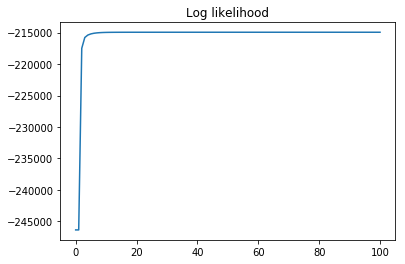

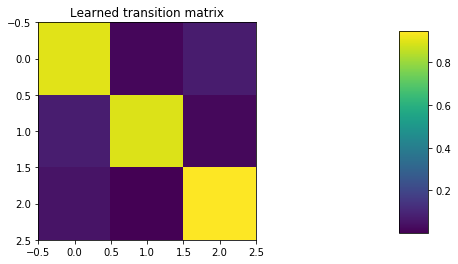

44
49
44


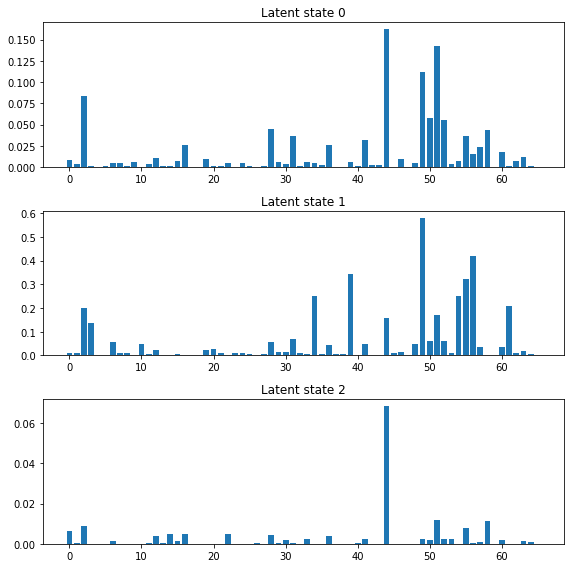

-------- Trial number 231 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


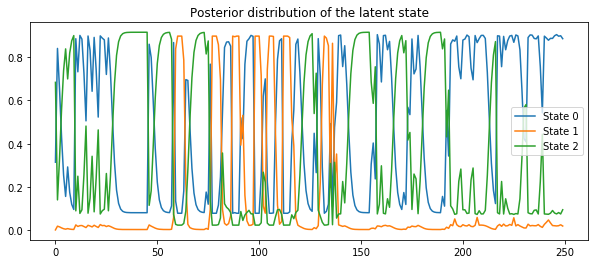

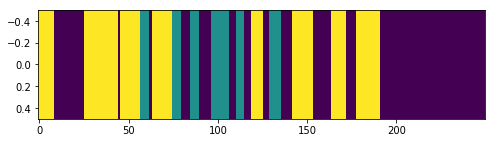

In [10]:
viz_hmm(res_visp)

-------- Trial number 284 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Left
Feedback: Reward


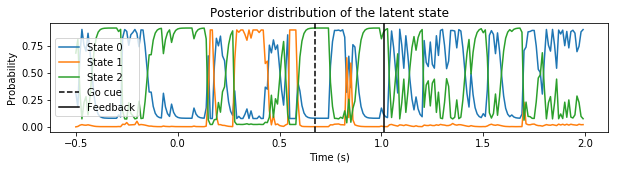

-------- Trial number 116 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


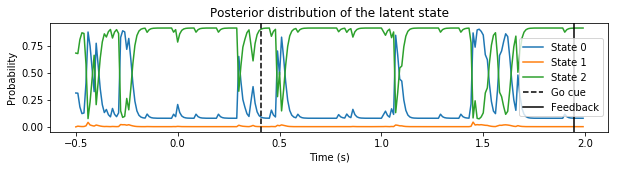

-------- Trial number 113 --------
Stimulus: Neither
Response: Left
Feedback: White noise


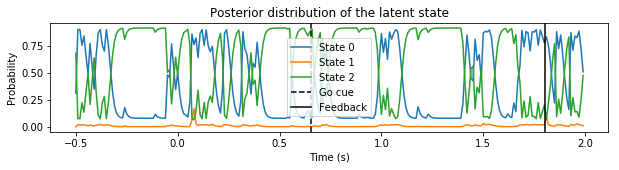

-------- Trial number 42 --------
Stimulus: Left 25.0%
Response: Left
Feedback: Reward


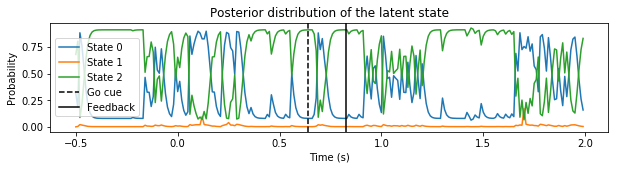

-------- Trial number 126 --------
Stimulus: Neither
Response: Left
Feedback: White noise


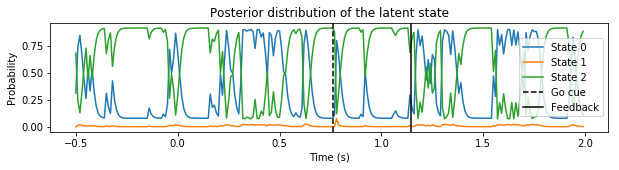

-------- Trial number 231 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


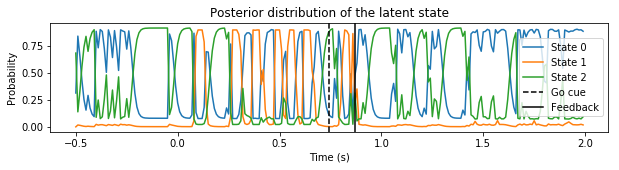

-------- Trial number 181 --------
Stimulus: Neither
Response: Right
Feedback: White noise


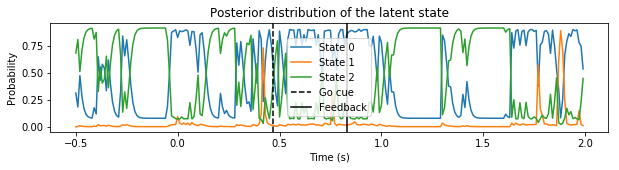

-------- Trial number 278 --------
Stimulus: Right 25.0%
Response: Right
Feedback: Reward


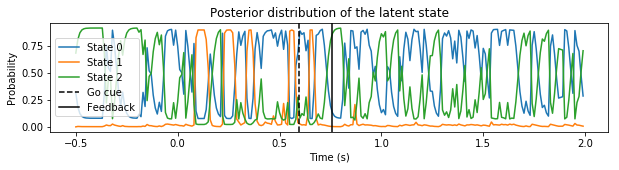

-------- Trial number 337 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


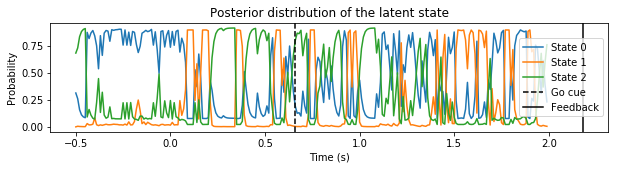

-------- Trial number 25 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


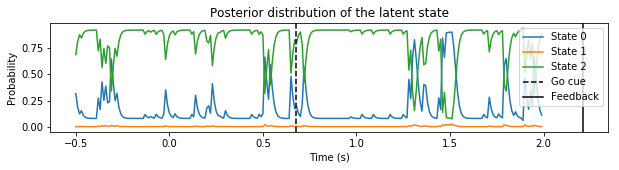

-------- Trial number 124 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


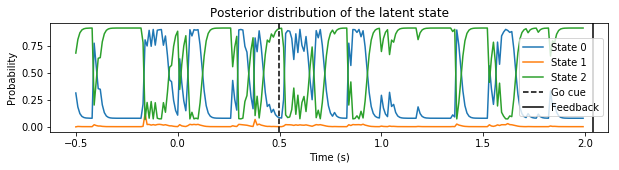

-------- Trial number 221 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


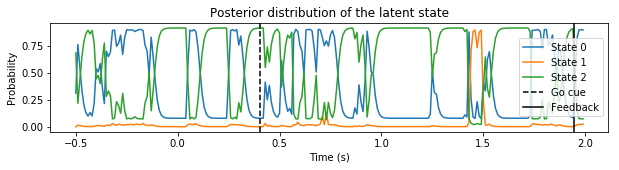

-------- Trial number 261 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


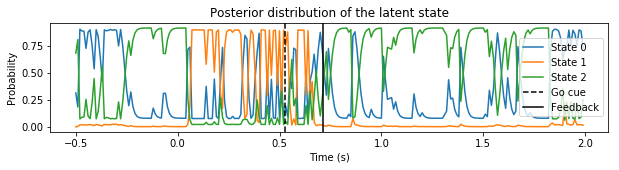

-------- Trial number 155 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


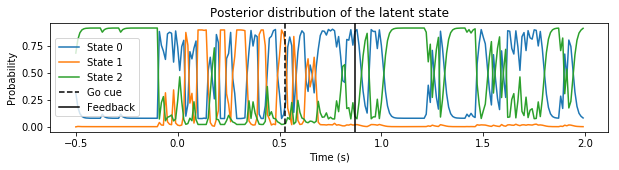

-------- Trial number 109 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


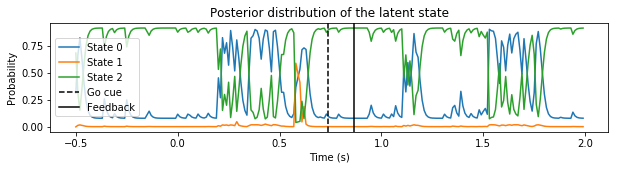

-------- Trial number 172 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


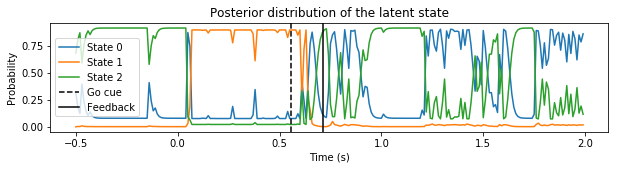

-------- Trial number 118 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


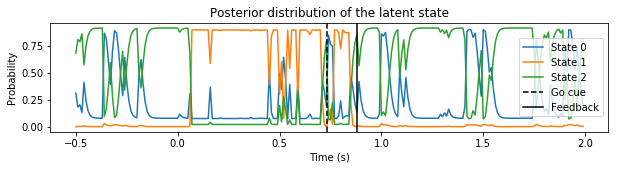

-------- Trial number 325 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


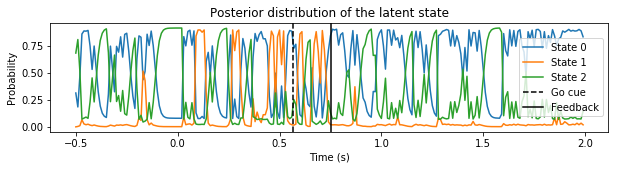

-------- Trial number 266 --------
Stimulus: Both left: 50.0%, right: 100.0%
Response: Left
Feedback: White noise


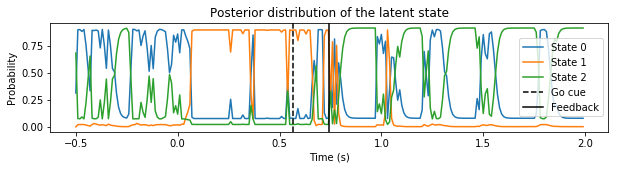

-------- Trial number 9 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


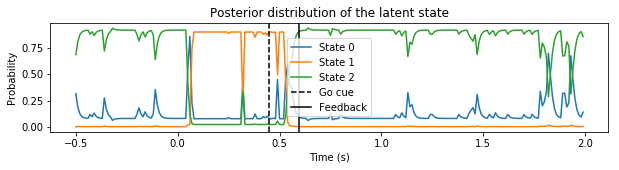

-------- Trial number 280 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


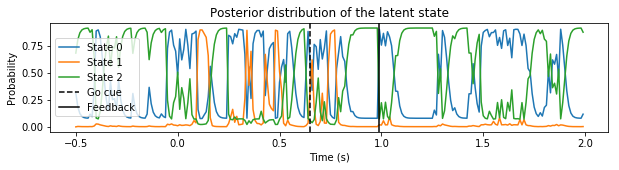

-------- Trial number 55 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


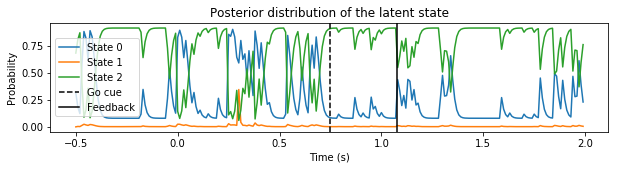

-------- Trial number 165 --------
Stimulus: Both left: 100.0%, right: 25.0%
Response: Left
Feedback: Reward


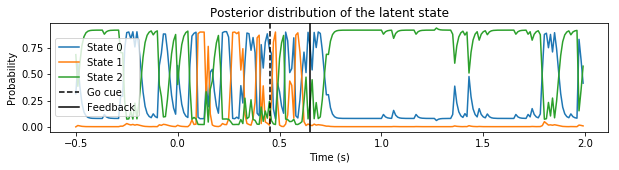

-------- Trial number 119 --------
Stimulus: Neither
Response: Right
Feedback: White noise


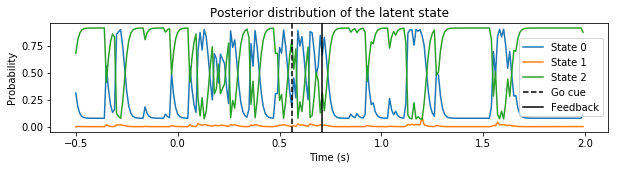

-------- Trial number 144 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


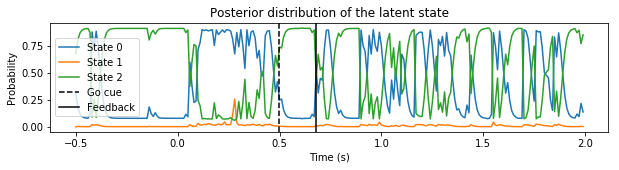

-------- Trial number 90 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


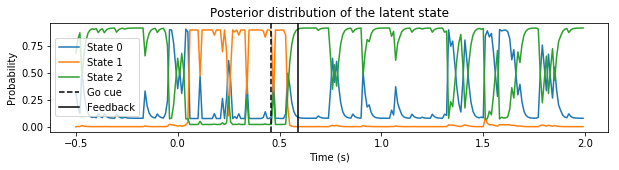

-------- Trial number 108 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


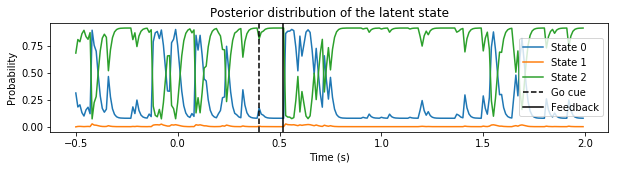

-------- Trial number 210 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


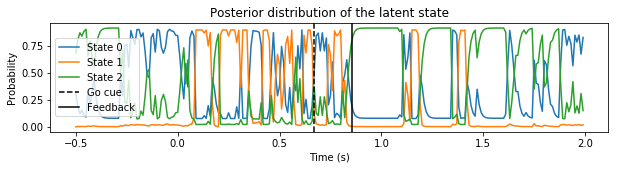

-------- Trial number 139 --------
Stimulus: Neither
Response: Right
Feedback: White noise


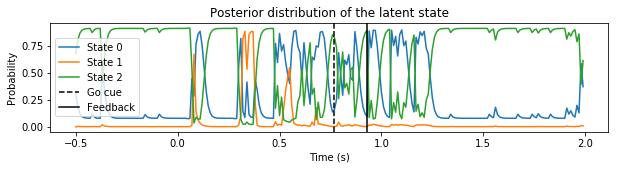

-------- Trial number 314 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


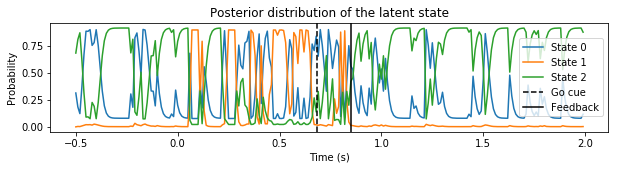

In [24]:
plot_posterior(res_visp, n_trials=30)

(250, 66)


<Container object of 250 artists>

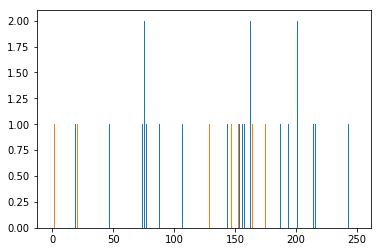

In [127]:
states, obs = res_visp[0].sample(250)
print(obs.shape)
plt.bar(np.arange(len(obs[:,2])), obs[:,2])
spks = alldat[11]['spks'][alldat[11]['brain_area'] == "VISp"]
plt.bar(np.arange(len(spks[2,0])), spks[2,0])

## VISam

In [110]:
session = 11
brain_area = "VISam"
n_states = 3

res_visam = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [17]:
viz_hmm(res_visam)

NameError: name 'res_visam' is not defined

-------- Trial number 284 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Left
Feedback: Reward


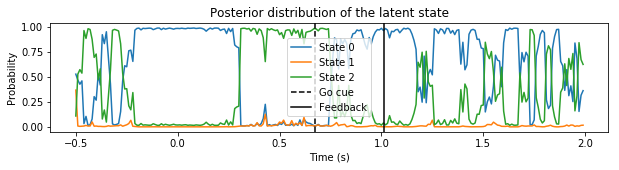

-------- Trial number 116 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


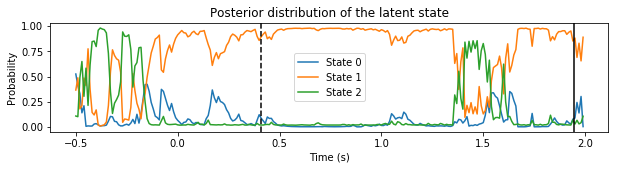

-------- Trial number 113 --------
Stimulus: Neither
Response: Left
Feedback: White noise


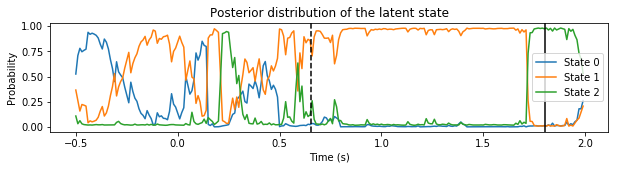

-------- Trial number 42 --------
Stimulus: Left 25.0%
Response: Left
Feedback: Reward


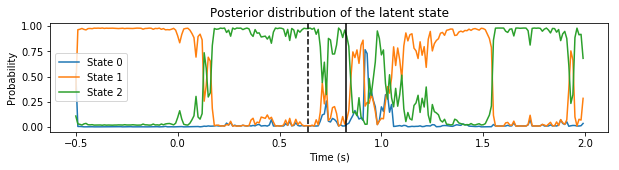

-------- Trial number 126 --------
Stimulus: Neither
Response: Left
Feedback: White noise


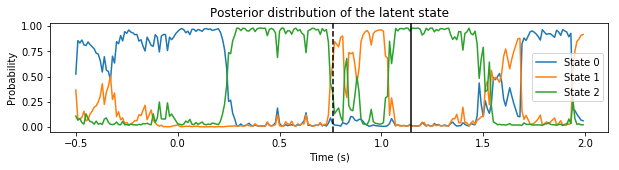

-------- Trial number 231 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


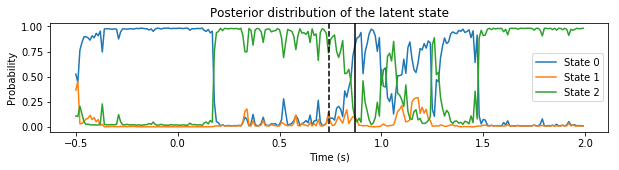

-------- Trial number 181 --------
Stimulus: Neither
Response: Right
Feedback: White noise


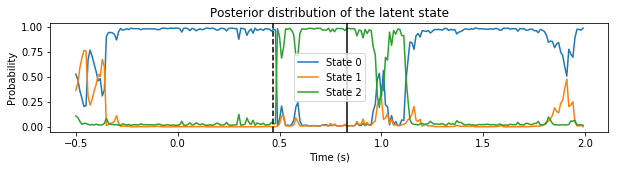

-------- Trial number 278 --------
Stimulus: Right 25.0%
Response: Right
Feedback: Reward


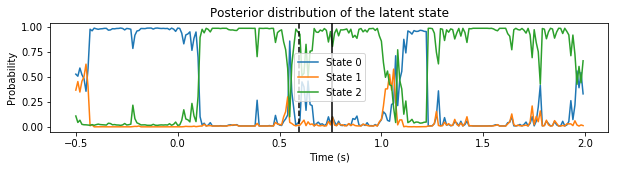

-------- Trial number 337 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


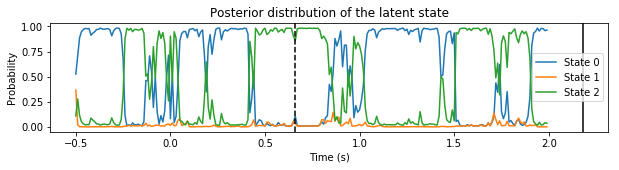

-------- Trial number 25 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


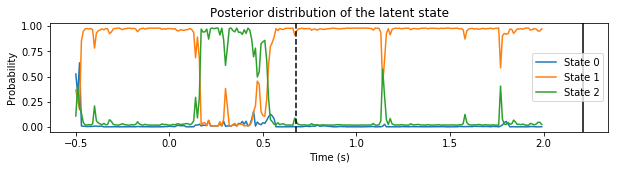

In [112]:
plot_posterior(res_visam)

# Session 21

## VISp

In [36]:
session = 21
brain_area = "VISp"
n_states = 5

res_visp_21 = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

-------- Trial number 334 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Left
Feedback: White noise


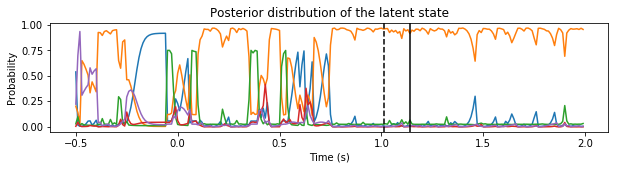

-------- Trial number 137 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


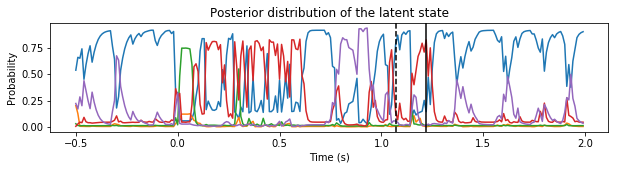

-------- Trial number 72 --------
Stimulus: Neither
Response: Right
Feedback: White noise


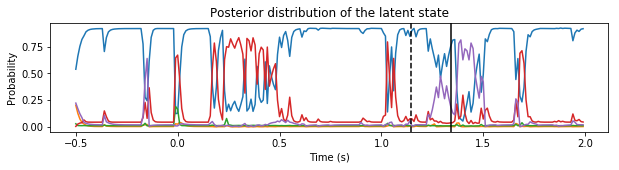

-------- Trial number 365 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


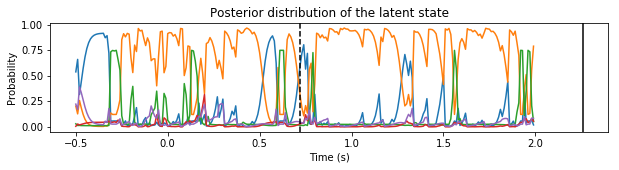

-------- Trial number 73 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


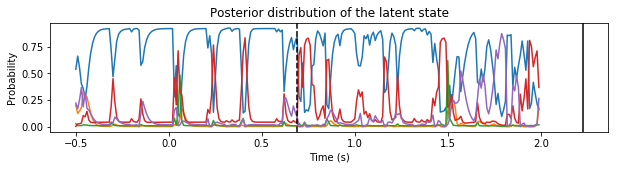

-------- Trial number 294 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


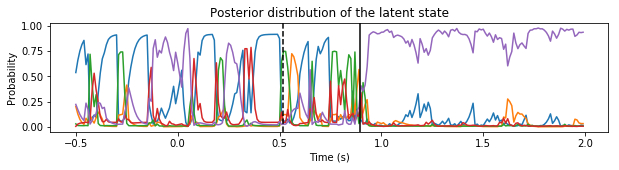

-------- Trial number 418 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


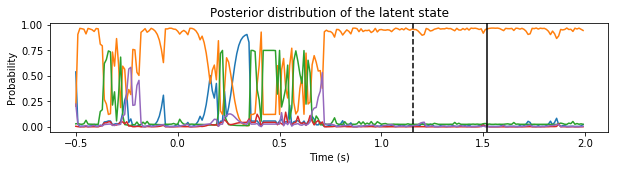

-------- Trial number 220 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


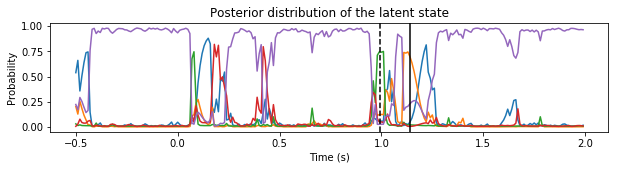

-------- Trial number 140 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


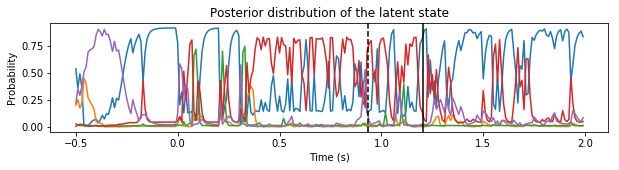

-------- Trial number 425 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


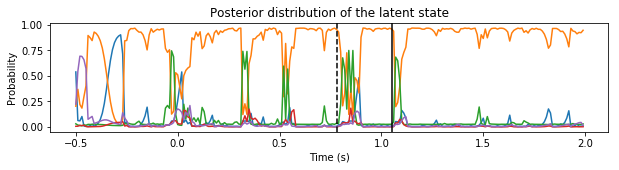

In [38]:
plot_posterior(res_visp_21, n_trials=10)

## MOs

In [8]:
session = 21
brain_area = "MOs"
n_states = 3

res_mos = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

-------- Trial number 334 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Left
Feedback: White noise


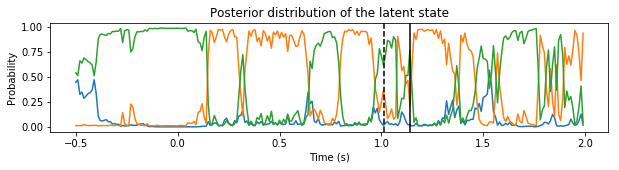

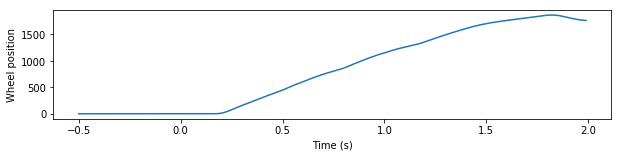

-------- Trial number 137 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


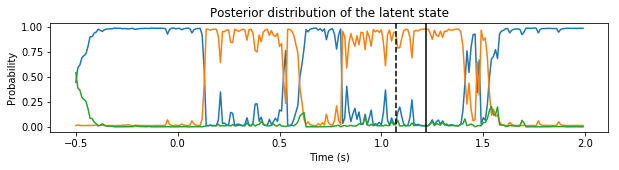

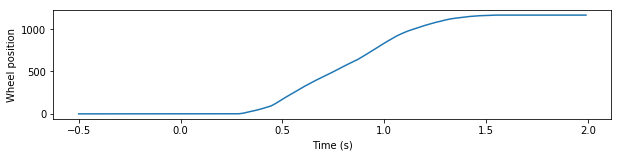

-------- Trial number 72 --------
Stimulus: Neither
Response: Right
Feedback: White noise


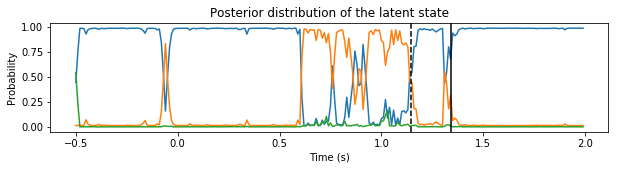

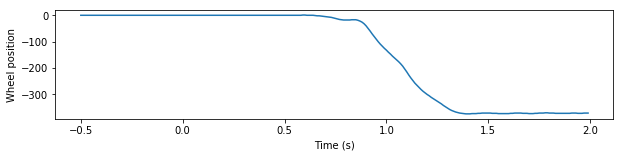

-------- Trial number 365 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


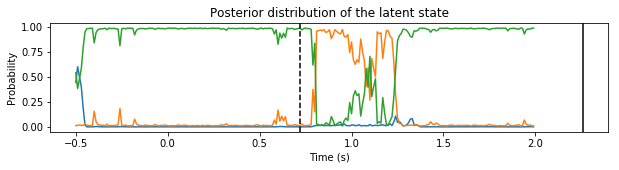

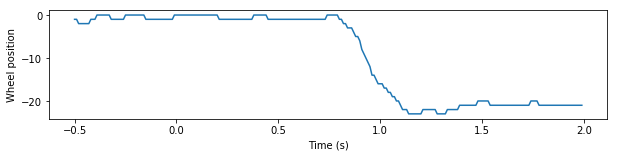

-------- Trial number 73 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


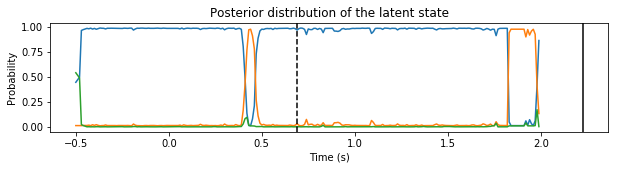

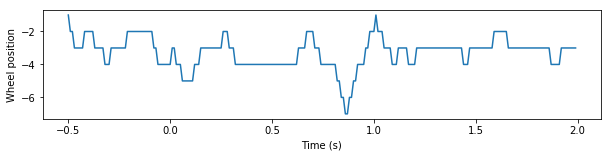

-------- Trial number 294 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


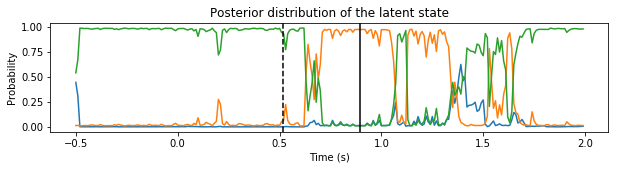

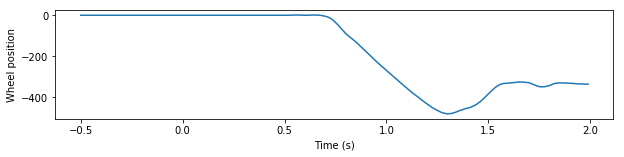

-------- Trial number 418 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


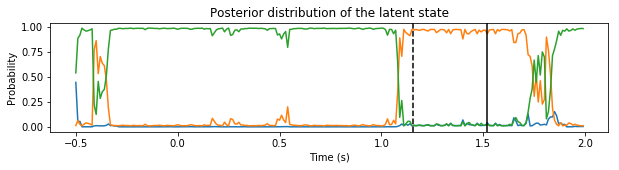

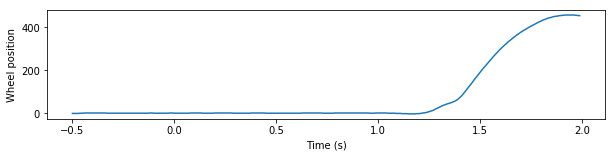

-------- Trial number 220 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


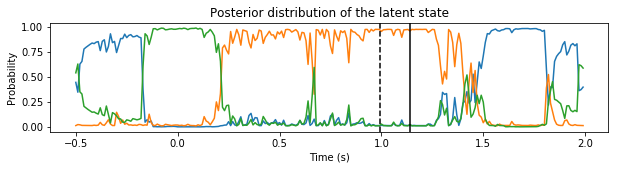

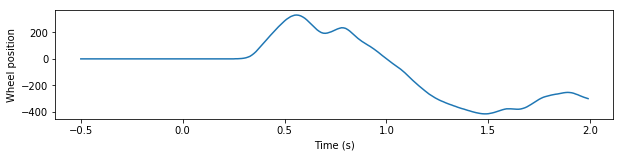

-------- Trial number 140 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


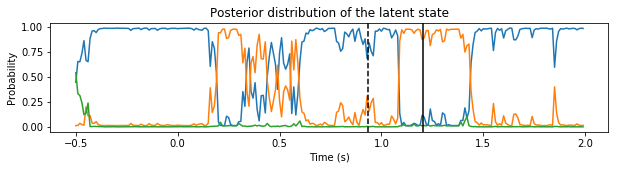

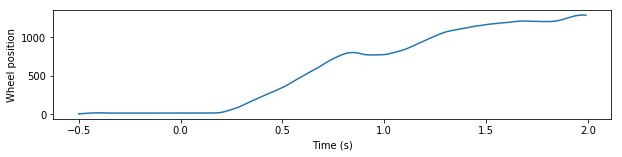

-------- Trial number 425 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


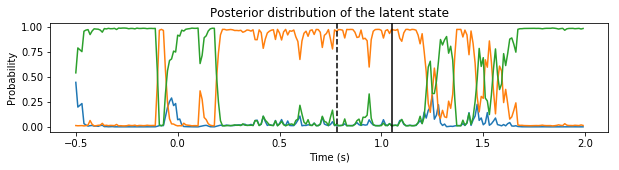

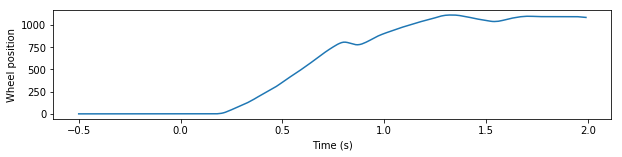

In [15]:
plot_posterior(res_mos, n_trials=10, plot_wheel=True)

In [86]:
corr = compute_corr(res_mos)

[-0.58241874  0.36968804  0.34260411]
False


In [87]:
session = 13
brain_area = "MOs"
n_states = 4

res_mos_4 = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [ ]:
plot_posterior(res_mos, n_trials=15)

## MD

In [136]:
session = 11
brain_area = "MD"
n_states = 5

res_md = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

-------- Trial number 284 --------
Stimulus: Both left: 50.0%, right: 25.0%
Response: Left
Feedback: Reward


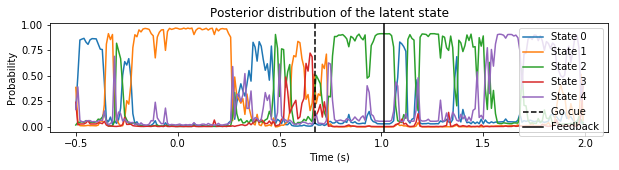

-------- Trial number 116 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


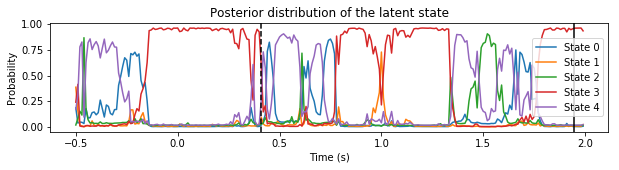

-------- Trial number 113 --------
Stimulus: Neither
Response: Left
Feedback: White noise


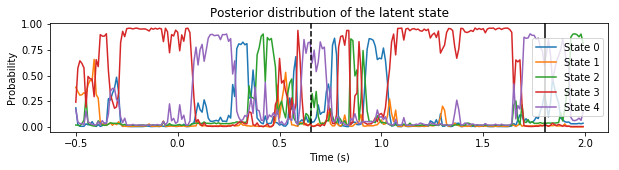

-------- Trial number 42 --------
Stimulus: Left 25.0%
Response: Left
Feedback: Reward


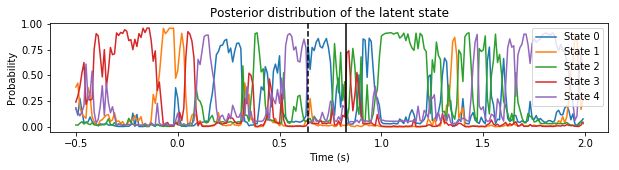

-------- Trial number 126 --------
Stimulus: Neither
Response: Left
Feedback: White noise


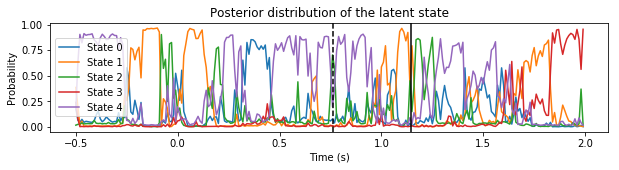

-------- Trial number 231 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


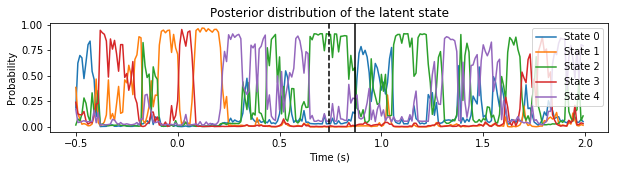

-------- Trial number 181 --------
Stimulus: Neither
Response: Right
Feedback: White noise


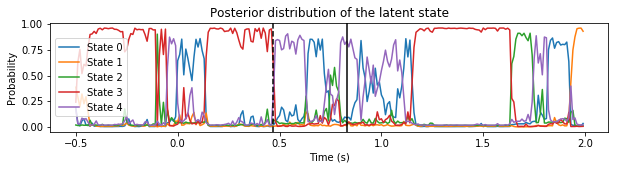

-------- Trial number 278 --------
Stimulus: Right 25.0%
Response: Right
Feedback: Reward


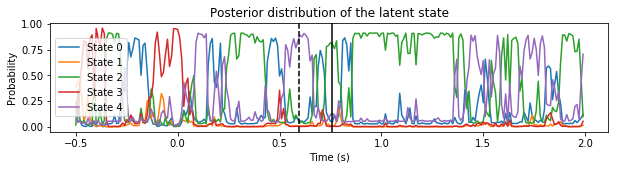

-------- Trial number 337 --------
Stimulus: Right 100.0%
Response: NoGo
Feedback: White noise


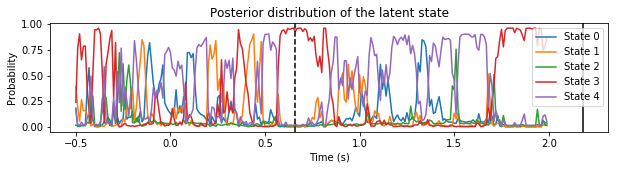

-------- Trial number 25 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


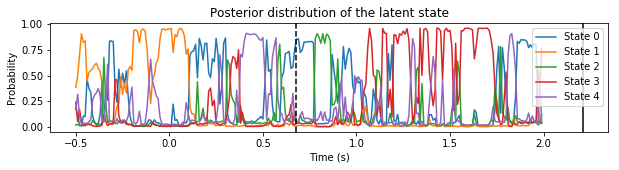

In [165]:
plot_posterior(res_md, n_trials=10)

## ACB

In [196]:
session = 21
brain_area = "ACB"
n_states = 5

res_acb = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [79]:
viz_hmm(res_acb)

NameError: name 'res_acb' is not defined

In [80]:
plot_posterior(res_acb, n_trials=20)

NameError: name 'res_acb' is not defined

## ACA

In [103]:
session = 21
brain_area = "ACA"
n_states = 2

res_aca = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=100)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [104]:
print("Explained variance: {:.2f}%".format(explained_var(res_aca).mean()*100))

Explained variance: 1.87%


-------- Trial number 334 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Left
Feedback: White noise


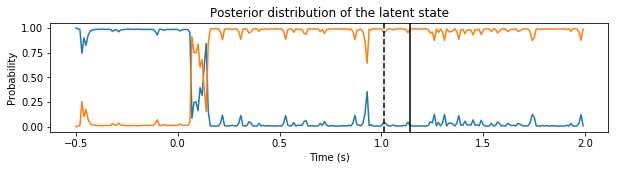

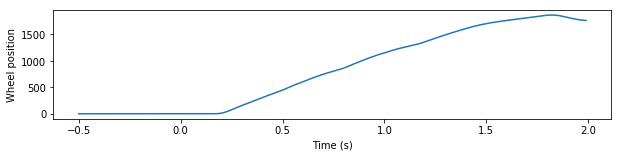

-------- Trial number 137 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


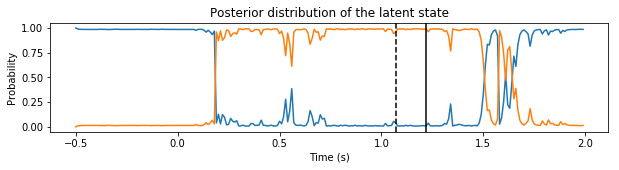

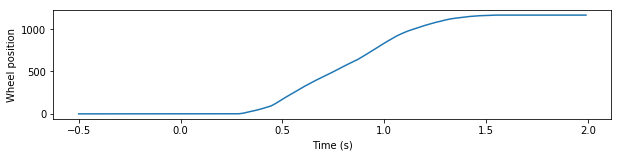

-------- Trial number 72 --------
Stimulus: Neither
Response: Right
Feedback: White noise


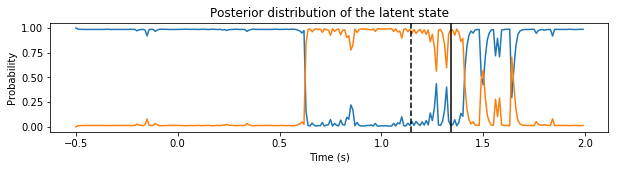

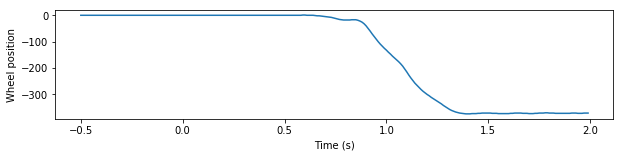

-------- Trial number 365 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


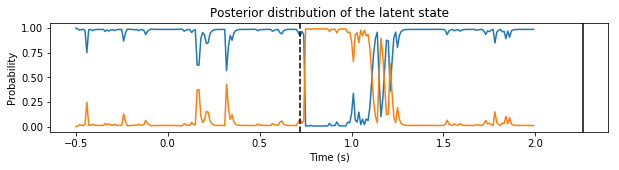

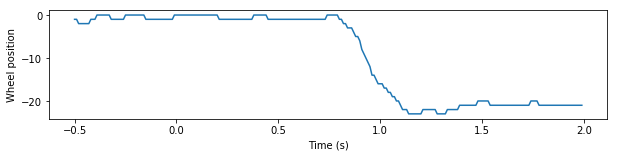

-------- Trial number 73 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


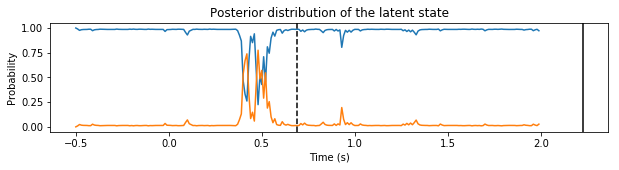

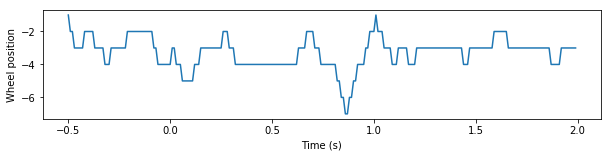

-------- Trial number 294 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


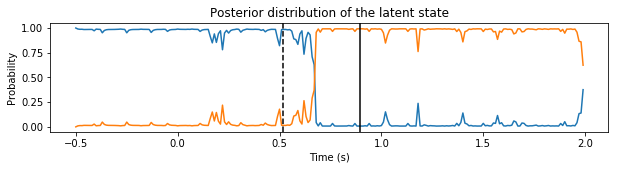

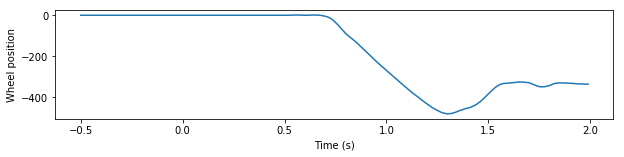

-------- Trial number 418 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


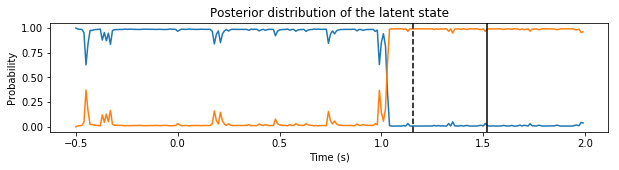

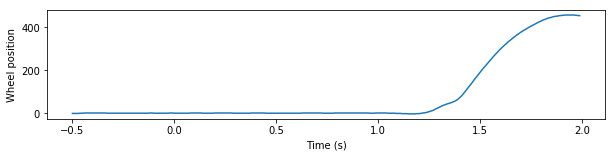

-------- Trial number 220 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


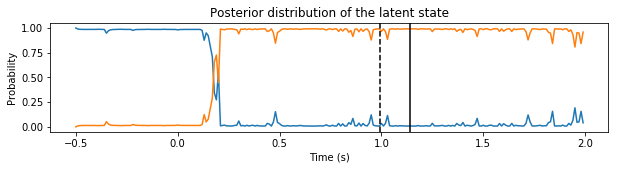

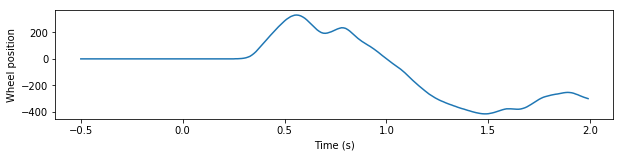

-------- Trial number 140 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


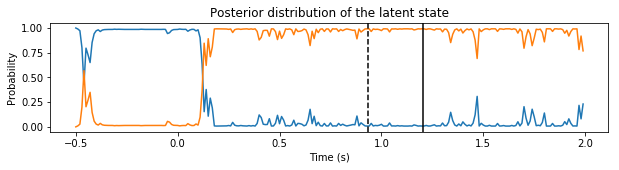

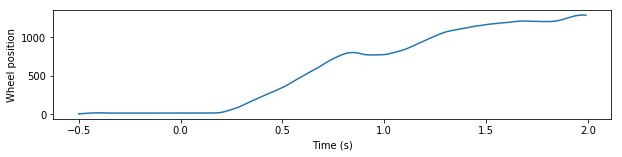

-------- Trial number 425 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


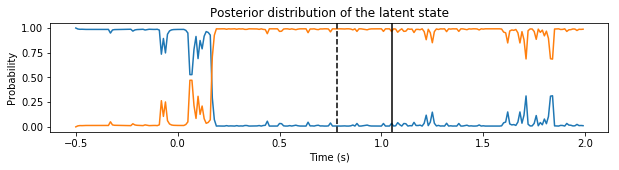

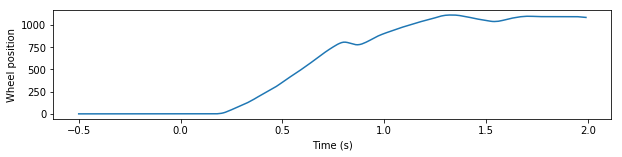

In [105]:
plot_posterior(res_aca, plot_wheel=True)

## RSP

In [125]:
session = 21
brain_area = "RSP"
n_states = 3

res_rsp = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=50)

HBox(children=(FloatProgress(value=0.0, max=50.0), HTML(value='')))

In [126]:
expl_var = explained_var(res_rsp)
expl_var = expl_var[expl_var > -1e100]
print("Explained variance: {:.2f}%".format(expl_var.mean()*100))

Explained variance: 0.99%


c:\users\nathancloos\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


-------- Trial number 334 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Left
Feedback: White noise


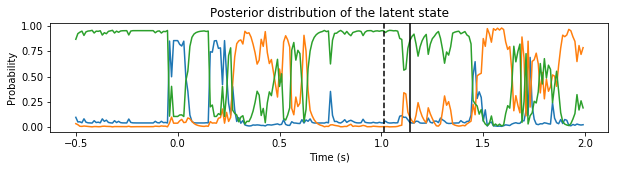

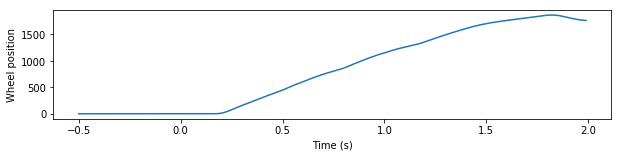

-------- Trial number 137 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


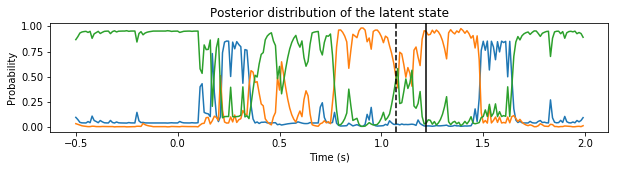

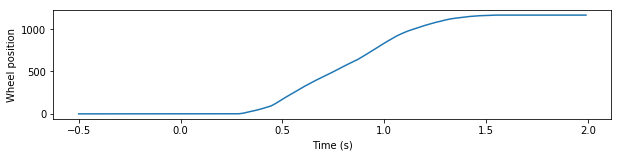

-------- Trial number 72 --------
Stimulus: Neither
Response: Right
Feedback: White noise


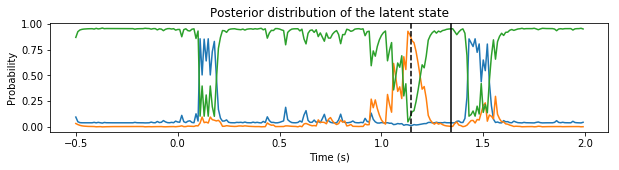

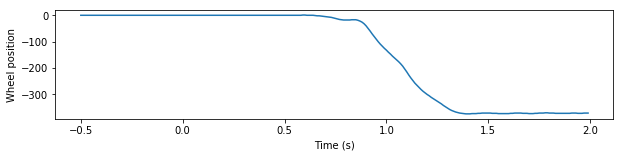

-------- Trial number 365 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


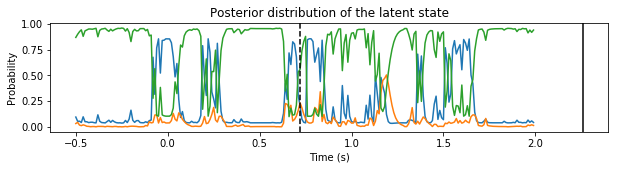

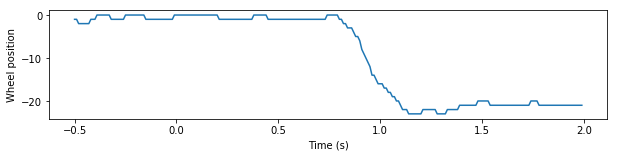

-------- Trial number 73 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


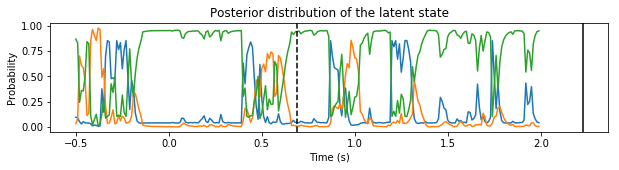

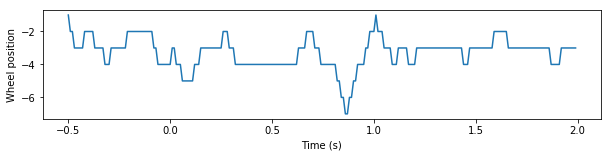

-------- Trial number 294 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


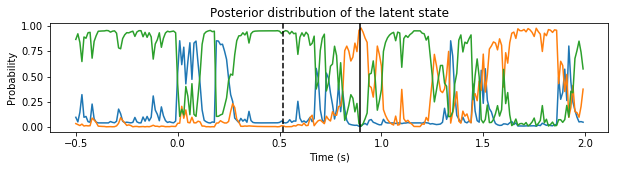

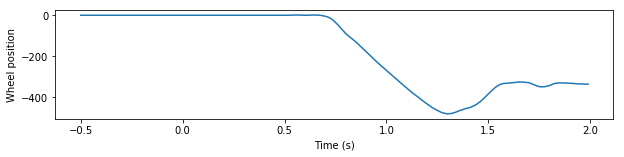

-------- Trial number 418 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


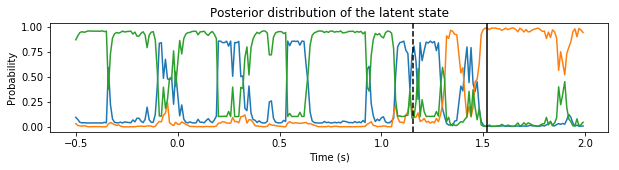

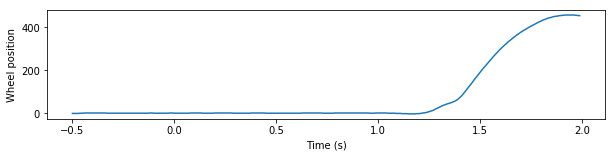

-------- Trial number 220 --------
Stimulus: Both left: 25.0%, right: 50.0%
Response: Right
Feedback: Reward


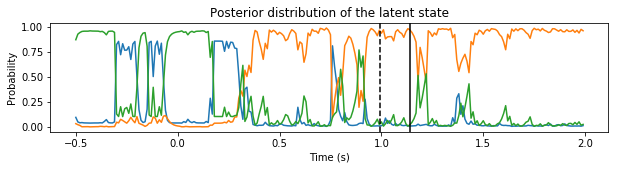

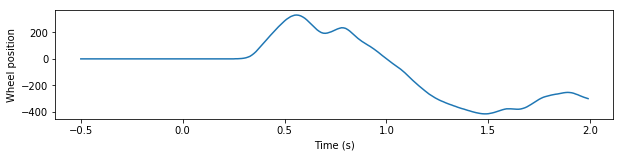

-------- Trial number 140 --------
Stimulus: Both left: 100.0%, right: 100.0%
Response: Left
Feedback: Reward


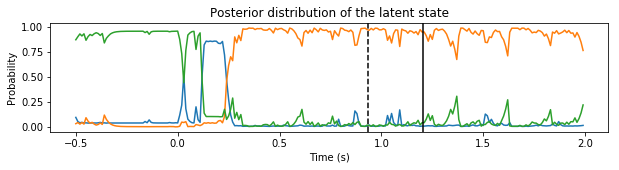

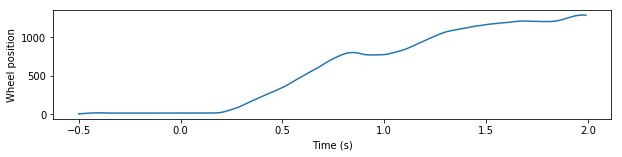

-------- Trial number 425 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


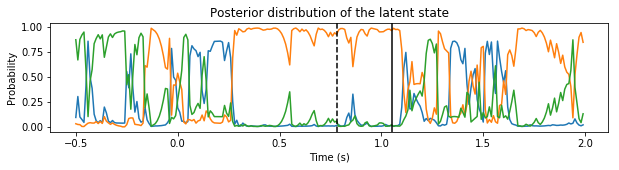

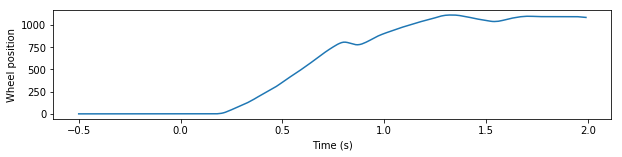

In [127]:
plot_posterior(res_rsp, plot_wheel=True)

# Session 25

Problem trial 41 !

## MOs

In [12]:
session = 25
brain_area = "MOs"
n_states = 4

res_mos_25 = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=50)

HBox(children=(FloatProgress(value=0.0, max=50.0), HTML(value='')))

In [13]:
print("Explained variance: {:.2f}%".format(explained_var(res_mos_25).mean()*100))

Explained variance: 0.56%


-------- Trial number 19 --------
Stimulus: Neither
Response: Right
Feedback: White noise


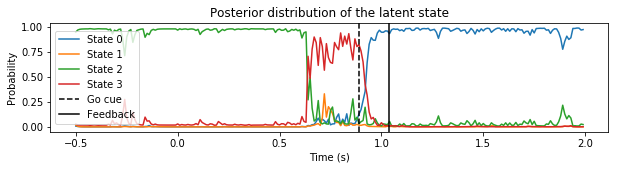

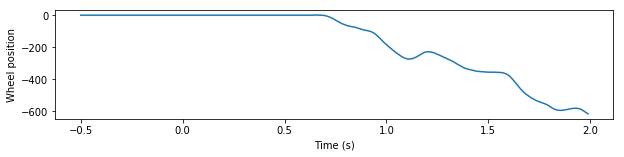

-------- Trial number 45 --------
Stimulus: Neither
Response: Left
Feedback: White noise


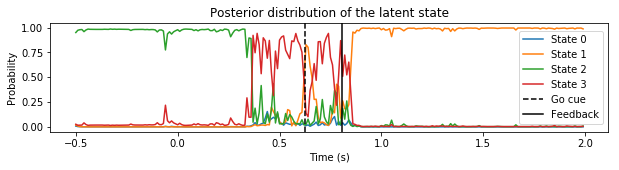

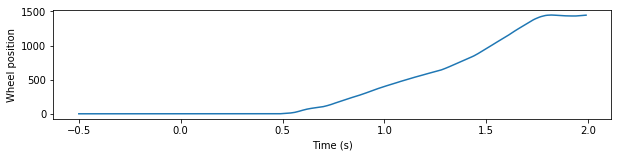

-------- Trial number 140 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


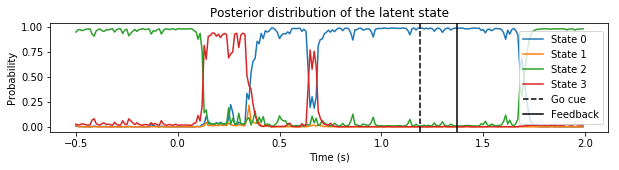

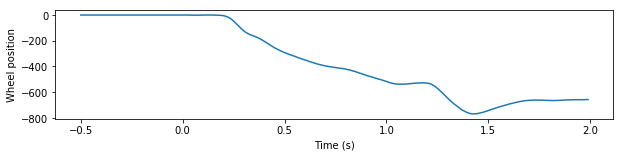

-------- Trial number 30 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: NoGo
Feedback: White noise


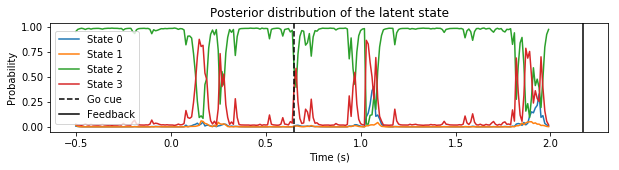

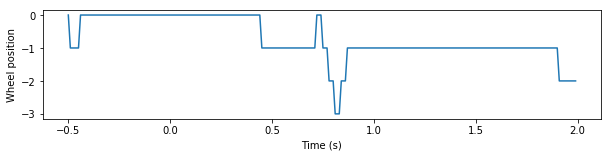

-------- Trial number 67 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


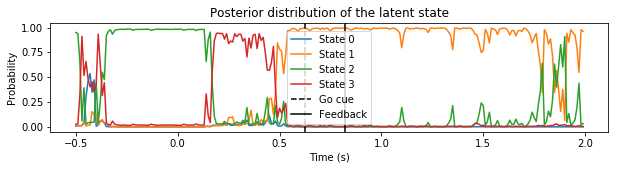

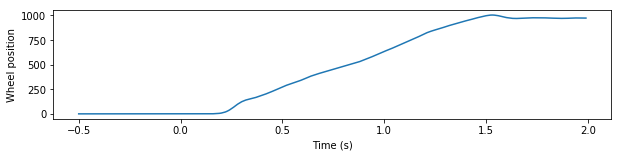

-------- Trial number 16 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Right
Feedback: Reward


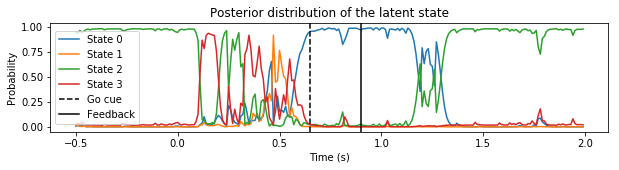

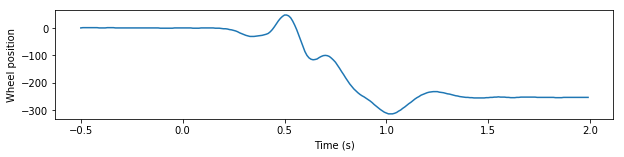

-------- Trial number 119 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


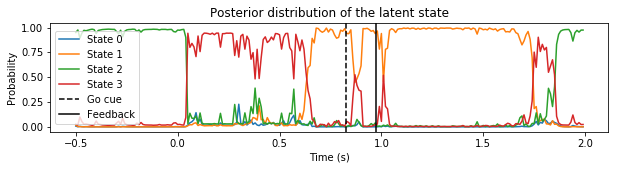

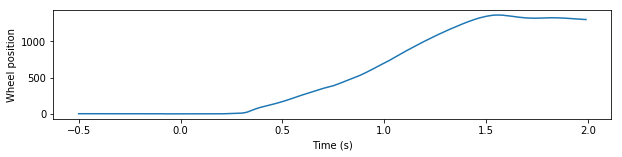

-------- Trial number 174 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


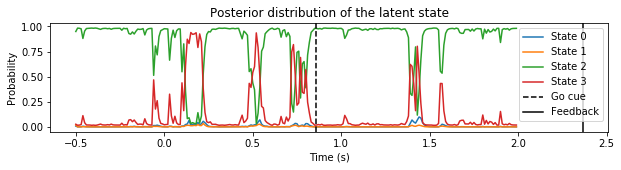

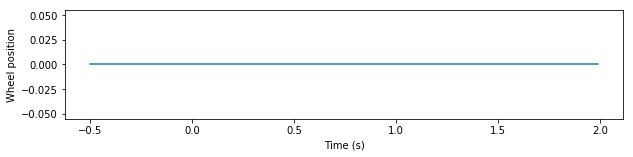

-------- Trial number 109 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


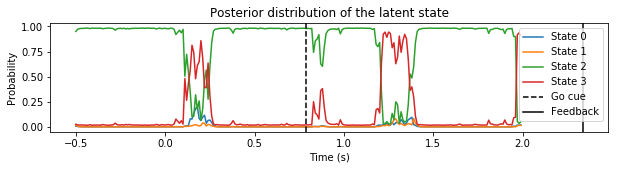

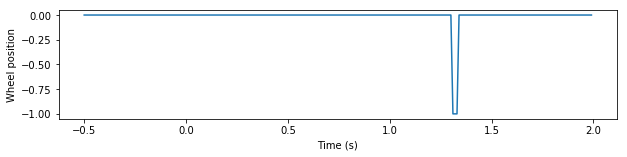

-------- Trial number 141 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


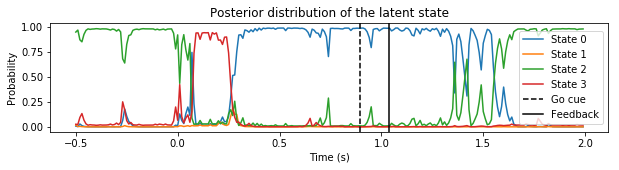

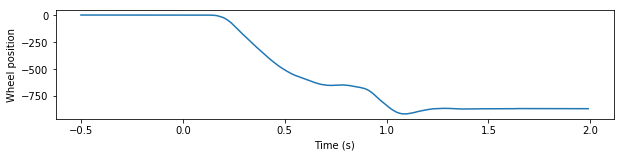

-------- Trial number 24 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


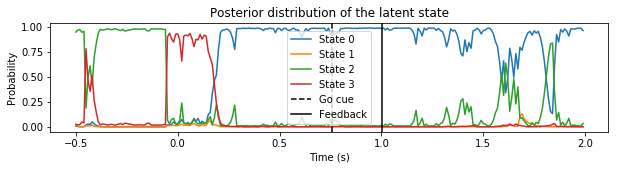

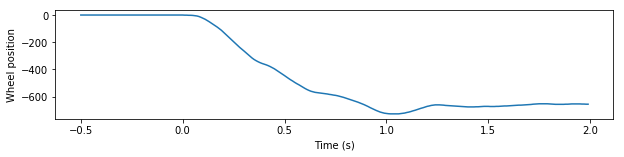

-------- Trial number 150 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


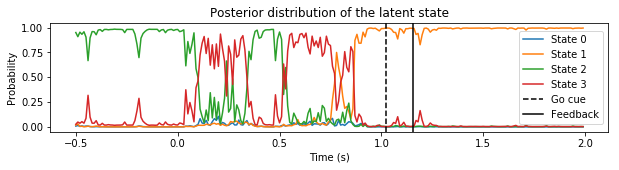

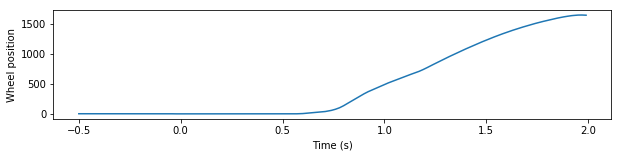

-------- Trial number 41 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


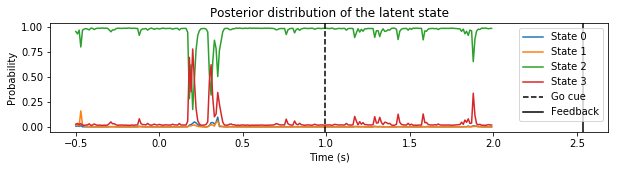

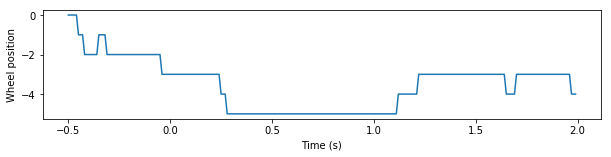

-------- Trial number 118 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


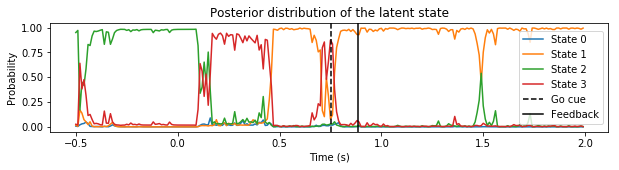

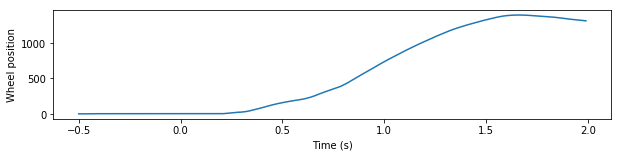

-------- Trial number 15 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


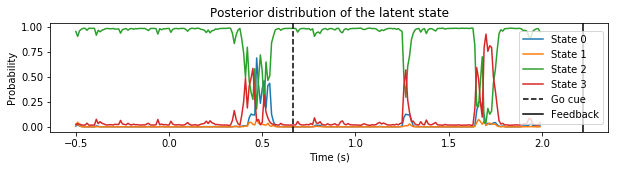

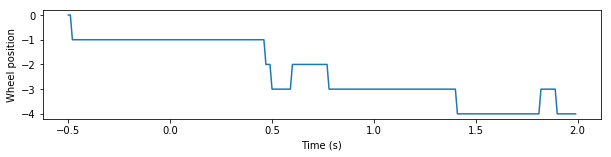

-------- Trial number 111 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


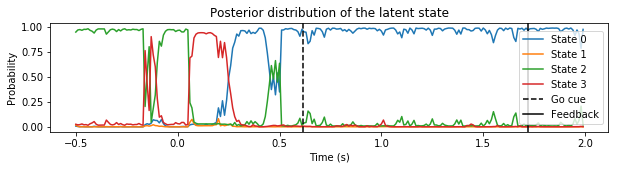

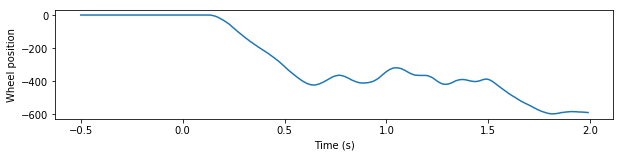

-------- Trial number 113 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


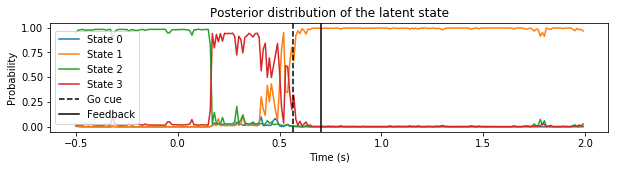

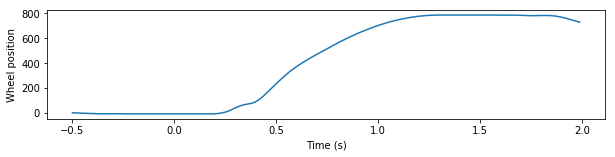

-------- Trial number 82 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


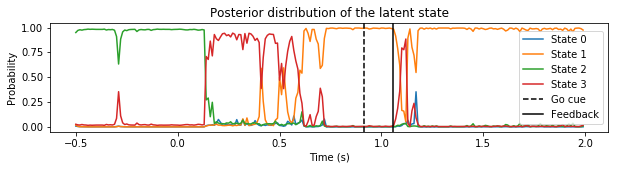

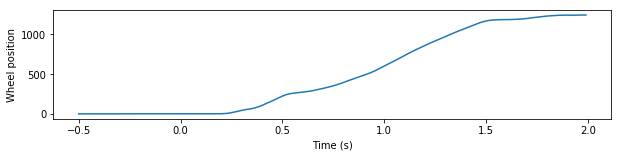

-------- Trial number 9 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


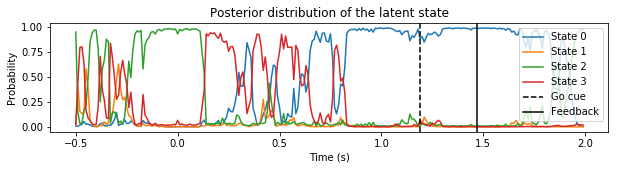

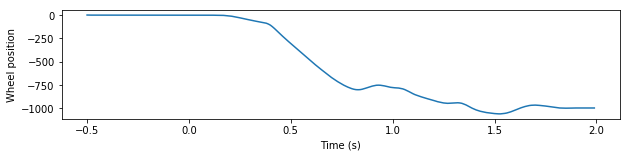

-------- Trial number 114 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


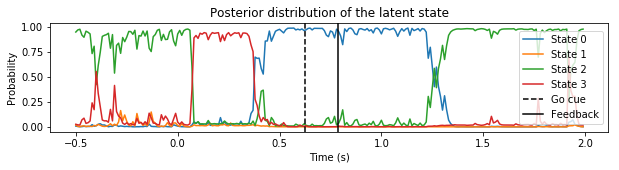

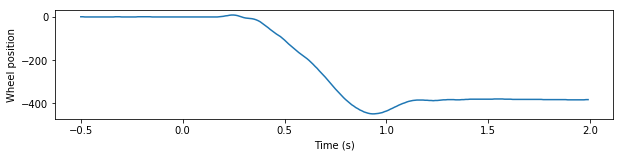

In [25]:
plot_posterior(res_mos_25, n_trials=20, plot_wheel=True)

## VISp

In [34]:
session = 25
brain_area = "VISp"
n_states = 4

res_visp_25 = train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=50)

HBox(children=(FloatProgress(value=0.0, max=50.0), HTML(value='')))

In [35]:
print("Explained variance: {:.2f}%".format(explained_var(res_visp_25).mean()*100))

Explained variance: -inf%


c:\users\nathancloos\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


-------- Trial number 19 --------
Stimulus: Neither
Response: Right
Feedback: White noise


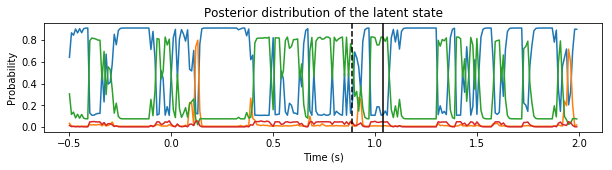

-------- Trial number 45 --------
Stimulus: Neither
Response: Left
Feedback: White noise


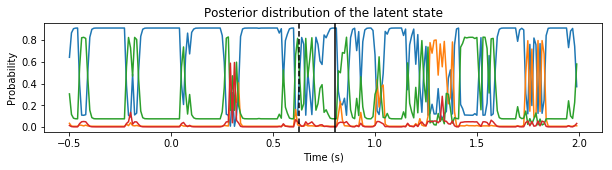

-------- Trial number 140 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


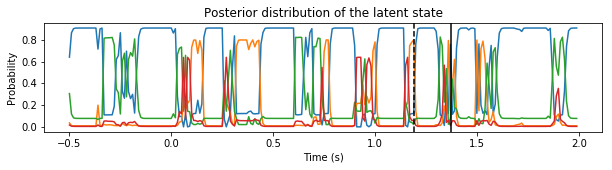

-------- Trial number 30 --------
Stimulus: Both left: 25.0%, right: 25.0%
Response: NoGo
Feedback: White noise


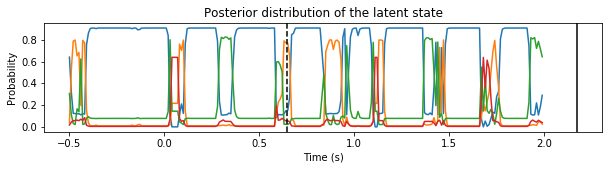

-------- Trial number 67 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


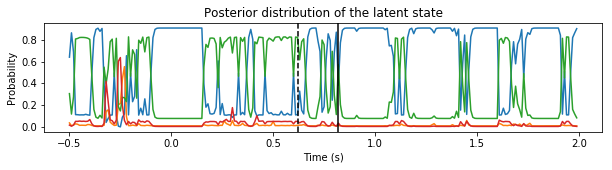

-------- Trial number 16 --------
Stimulus: Both left: 50.0%, right: 50.0%
Response: Right
Feedback: Reward


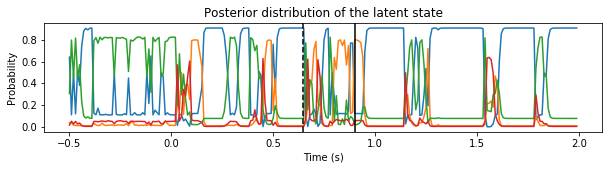

-------- Trial number 119 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


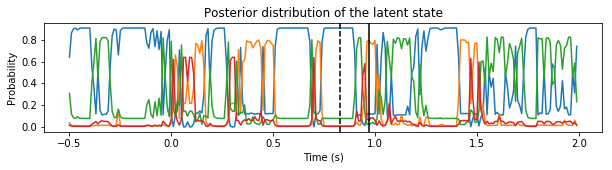

-------- Trial number 174 --------
Stimulus: Left 100.0%
Response: NoGo
Feedback: White noise


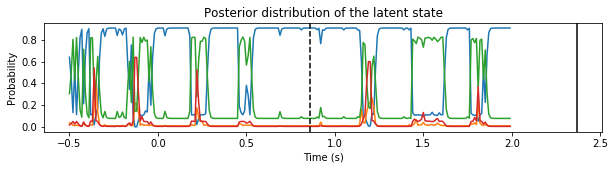

-------- Trial number 109 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


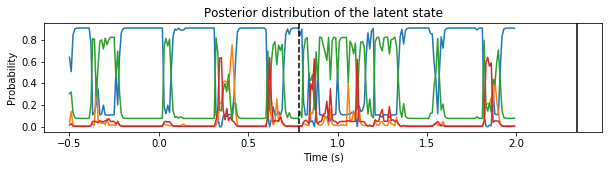

-------- Trial number 141 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


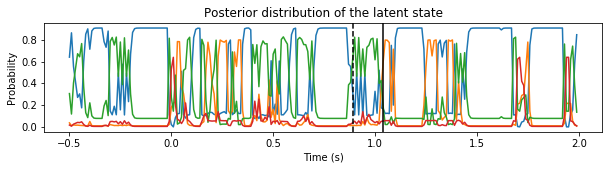

-------- Trial number 24 --------
Stimulus: Right 100.0%
Response: Right
Feedback: Reward


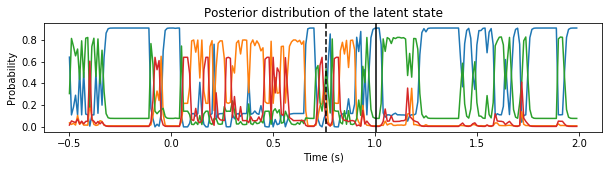

-------- Trial number 150 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


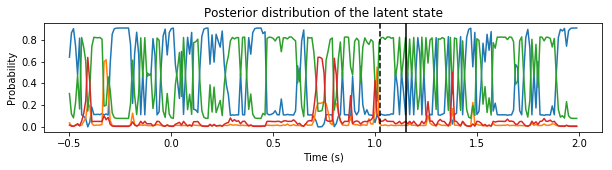

-------- Trial number 41 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


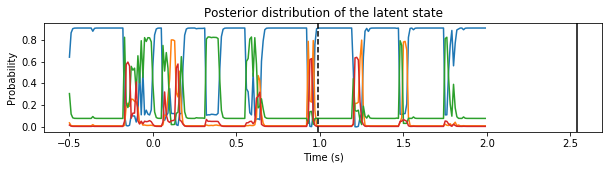

-------- Trial number 118 --------
Stimulus: Left 100.0%
Response: Left
Feedback: Reward


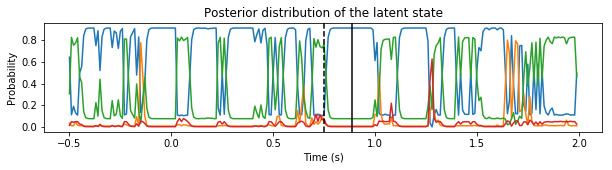

-------- Trial number 15 --------
Stimulus: Neither
Response: NoGo
Feedback: Reward


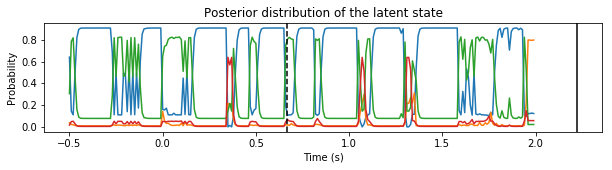

-------- Trial number 111 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


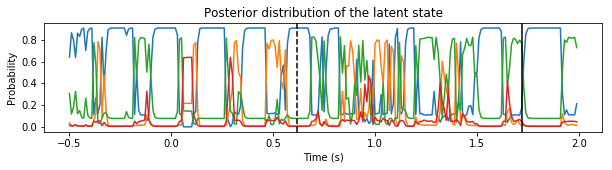

-------- Trial number 113 --------
Stimulus: Left 50.0%
Response: Left
Feedback: Reward


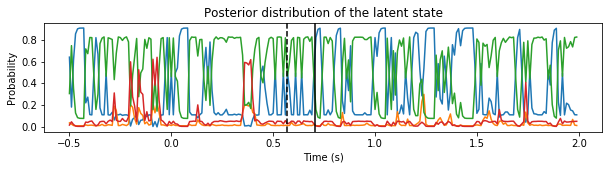

-------- Trial number 82 --------
Stimulus: Both left: 100.0%, right: 50.0%
Response: Left
Feedback: Reward


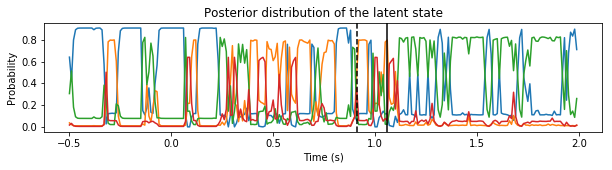

-------- Trial number 9 --------
Stimulus: Right 50.0%
Response: Right
Feedback: Reward


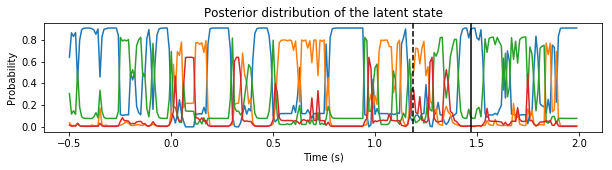

-------- Trial number 114 --------
Stimulus: Both left: 25.0%, right: 100.0%
Response: Right
Feedback: Reward


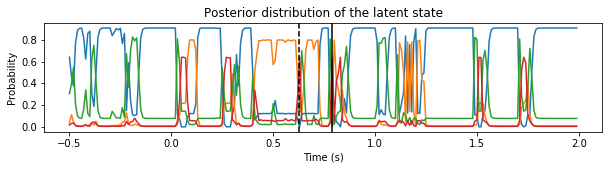

In [36]:
plot_posterior(res_visp_25, n_trials=20, plot_wheel=False)